# Análise de Churn - PetLove

Neste notebook, eu analiso uma amostra de dados a respeito de *churn* de clientes fornecida pela equipe da PetLove e sugiro maneiras de diminuir esse indicador ruim.

As etapas que eu segui nesse processo são:

1. Exploração inicial dos dados
    1. Receita gerada pelos clientes que cancelaram
    2. Se há coincidência de bairros entre os clientes que cancelaram
    3. Qual versão da assinatura obteve o maior número de cancelamentos
    4. Após quanto tempo sem comprar um cliente costuma cancelar?
    5. Qual canal de sourcing costuma ter o maior número de cancelamentos?
2. Limpeza do dados
3. Exploração secundária e visualização de algumas métricas
    1. Conceito de *churn limpo*, isto é, clientes que cancelaram a assinatura e que realmente utilizaram algum dos serviços oferecidos
4. Proposição de soluções



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('data/data-petlove.csv')
df['deleted_date'] = df['deleted_at'].str.slice(start=0, stop=10)
df['deleted_month_date'] = df['deleted_at'].str.slice(start=0, stop=7)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   created_at          10000 non-null  object 
 2   updated_at          10000 non-null  object 
 3   deleted_at          505 non-null    object 
 4   name_hash           10000 non-null  object 
 5   email_hash          10000 non-null  object 
 6   address_hash        10000 non-null  object 
 7   birth_date          10000 non-null  object 
 8   status              10000 non-null  object 
 9   version             10000 non-null  object 
 10  city                10000 non-null  object 
 11  state               10000 non-null  object 
 12  neighborhood        10000 non-null  object 
 13  last_date_purchase  10000 non-null  object 
 14  average_ticket      10000 non-null  float64
 15  items_quantity      10000 non-null  int64  
 16  all_r

In [4]:
df.describe()

,average_ticket,items_quantity,all_revenue,all_orders,recency
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,216.894709,8.49980,1174.888603,5.415400,67.192900
std,22.757213,3.02604,763.141973,3.457577,175.723276
min,131.378672,1.00000,0.000000,0.000000,1.000000
25%,201.398851,6.00000,494.873564,2.000000,31.000000
50%,217.019478,8.00000,1172.751918,5.000000,35.000000
75%,232.455042,11.00000,1798.475045,8.000000,39.000000
max,303.386848,19.00000,3225.654163,11.000000,1820.000000


In [7]:
df.head()

,id,created_at,updated_at,deleted_at,name_hash,email_hash,address_hash,birth_date,status,version,city,state,neighborhood,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,deleted_date,deleted_month_date
0,8bf7960e-3b93-468b-856e-6c6c5b56f52b,08/15/17 07:05 AM,01/14/21 11:23 AM,NaN,312d206168a318614897e8ccac43bff9,83eb3aed9a44377df80ce876dce92c9a,8b4bfaa0cbc41a16f46da15ddcd6a907,07/10/74 12:00 AM,active,2.31.7,Peixoto da Praia,AM,Aparecida 7ª Seção,01/14/21 11:23 AM,151.142942,10,906.857651,6,35,crm,NaN,NaN
1,a39535b5-4647-4680-b4f6-3aed57c1f1ff,12/31/19 09:53 PM,01/08/21 11:23 AM,NaN,de448fcb47d0d6a873b2eef52b5ee595,72678bb35e2ac84ed373e81dd9dca28c,22f1cfa1847f38da3f3cb114dd2b9247,07/06/40 12:00 AM,paused,3.30.12,Fernandes,RR,Santa Isabel,01/08/21 11:23 AM,236.991790,4,236.991790,1,41,organic_search,NaN,NaN
2,dc067cd2-c021-42bd-8c0e-beb267280e66,03/07/19 11:46 PM,01/07/21 11:23 AM,NaN,cb09e447ddc38283373d56bb46498e6a,668f4ee9add29c7bd02c485f1b7509e3,6cb47446a086ee6483b3eb954f11467a,03/18/63 12:00 AM,active,3.28.9,Lopes,RR,Estrela,01/07/21 11:23 AM,211.955597,13,2331.511572,11,42,organic_search,NaN,NaN
3,b5e4caeb-3a9b-49ed-aa33-5acd06b162c1,07/21/18 10:17 AM,01/10/21 11:23 AM,NaN,52593437a405b11b3557170680ef80c8,d3fb45188d95c8d7cc49da5b4f727c86,0a6f0c54db1e6f19347f96b50f8092a4,11/21/80 12:00 AM,active,3.34.3,Campos do Campo,PE,Confisco,01/10/21 11:23 AM,204.113227,8,1224.679359,6,39,organic_search,NaN,NaN
4,d4ff61fc-f008-4e19-b8ae-bd70cfa3ae27,06/08/18 12:09 PM,01/18/21 11:23 AM,NaN,dbda4b778a966c21904238ed2d2005db,a0f76bc49b4c43327b536da6e1a1465e,143b9f169b4fa1692f6d79b5682169b5,07/07/59 12:00 AM,active,3.19.8,das Neves,RJ,Vila Suzana Segunda Seção,01/18/21 11:23 AM,252.940997,9,2023.527980,8,31,crm,NaN,NaN


In [53]:
df.loc[df['deleted_at'].notna()]

,id,created_at,updated_at,deleted_at,name_hash,email_hash,address_hash,birth_date,status,version,...,neighborhood,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,deleted_date,deleted_month_date
12,9e755f27-01e7-4e2f-aaba-18f733f3e3d9,2016-12-06 20:43:20.000000,2018-06-17 23:59:08.000000,2018-06-17 23:59:08.000000,1fe10e9a8553f96bf3ea94c0d743a94c,b5bdb61e489e0c5582edb5d359945ff7,e1ca805110fa65e1a6f2aa7dea2667b3,1966-01-25 00:00:00.000000,canceled,5.31.5,...,Ipe,2017-07-13 06:36:50.000000,190.017737,9,1140.106424,6,1316,crm,2018-06-17,2018-06
22,03718a9c-d9d8-42e9-aae2-3fce5eff9e21,2017-09-21 09:33:03.000000,2018-12-11 04:09:05.000000,2018-12-11 04:09:05.000000,3eee22cd440a82d3c1df7f066f2f49ae,8706847e8ce006fa642aa292c064b6da,acd13116ffe548a1b1573ef17f594bd5,1979-10-18 00:00:00.000000,canceled,2.15.3,...,Nossa Senhora De Fátima,2017-11-09 17:40:02.000000,234.207818,11,468.415636,2,1196,organic_search,2018-12-11,2018-12
33,9e51382b-e7dc-4430-9d04-f39b36d25cf6,2020-09-02 18:53:20.000000,2021-02-14 18:19:48.000000,2021-02-14 18:19:48.000000,8398f79a4d9b2f337bcdaa8d815630b6,074864956cb319acf9173333e1d03131,6ff0617220e330d8b5a3ab89ce29c9b2,1975-11-08 00:00:00.000000,canceled,4.22.8,...,Conjunto Floramar,2020-12-24 06:42:59.000000,215.223848,10,1076.119241,5,56,organic_search,2021-02-14,2021-02
63,5545e738-de0f-4740-b517-cc480aa5bc30,2017-02-06 09:03:14.000000,2020-08-24 09:44:52.000000,2020-08-24 09:44:52.000000,9dd8d6c398316660d3d2c7006b4d5dc9,da07d4746d9de26c763438f7bc4cb3c3,367c512a70474df5e4b7c01a989f6f28,1976-07-28 00:00:00.000000,canceled,4.28.11,...,Tupi A,2017-07-23 11:11:41.000000,211.300132,6,1267.800790,6,1306,organic_search,2020-08-24,2020-08
86,ab77fb95-a328-4bdd-869d-a7353f6bb2f3,2020-11-25 08:12:33.000000,2020-12-08 06:45:51.000000,2020-12-08 06:45:51.000000,b50a5ad2dc8a0686ef123ccd77d35898,44a07b4f8c87bdaa7df03cf342ae5f80,0a70d0ca8dbcbce2cd10a63aa846263e,1949-08-11 00:00:00.000000,canceled,4.32.5,...,São Jorge 2ª Seção,2020-11-27 21:42:09.000000,214.151632,15,0.000000,0,82,direct,2020-12-08,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817,1a599fde-745e-4aaa-ae68-61f3773effc2,2020-11-27 14:17:35.000000,2020-12-01 21:45:41.000000,2020-12-01 21:45:41.000000,e05b2a192e6946f58d1b5035cfd7743c,d63454de3024df5479e4da3d752a4600,00892590f0eced4c119ff7845901bd3c,1956-08-28 00:00:00.000000,canceled,4.37.3,...,Granja Werneck,2020-11-28 08:34:42.000000,183.850017,9,0.000000,0,82,crm,2020-12-01,2020-12
9840,b5b91dd6-2db2-4c7e-81b5-76df58fc1da6,2018-11-11 10:18:51.000000,2020-03-20 21:22:18.000000,2020-03-20 21:22:18.000000,a68ee65eb5331ad5b0522e4990dca876,1cf1eb5319afda5239b0638bd19bc64c,ceaa7b3b77a4b7aad84fd63f89671beb,1993-03-16 00:00:00.000000,canceled,3.40.6,...,Pantanal,2019-06-06 12:36:09.000000,224.884005,4,899.536020,4,622,none,2020-03-20,2020-03
9927,dd1739ce-40b9-442a-83a5-be534559eabb,2018-12-23 14:02:25.000000,2019-07-26 12:01:06.000000,2019-07-26 12:01:06.000000,450a83ba0e20fc856b6468e4fe367b24,4db08911475590e65305922ce4077d42,d0500fb6ab9402d39223ca9f9620c749,1960-02-01 00:00:00.000000,canceled,5.17.8,...,Calafate,2019-02-08 23:07:07.000000,233.283850,3,1632.986947,7,740,none,2019-07-26,2019-07
9945,07e9a614-251d-4b42-b82a-bfc5ce71ec8c,2021-02-04 22:59:42.000000,2021-02-16 12:45:09.000000,2021-02-16 12:45:09.000000,2b7ae78e437a558b2e095ef83a85712d,64c55ce42e515bbeb7d0e18345ddce20,d6980f507c4beac5534b5fef3c1c74d6,1982-04-30 00:00:00.000000,canceled,4.6.4,...,Apolonia,2021-02-15 21:55:58.000000,231.366753,11,0.000000,0,2,telegram_whatsapp,2021-02-16,2021-02


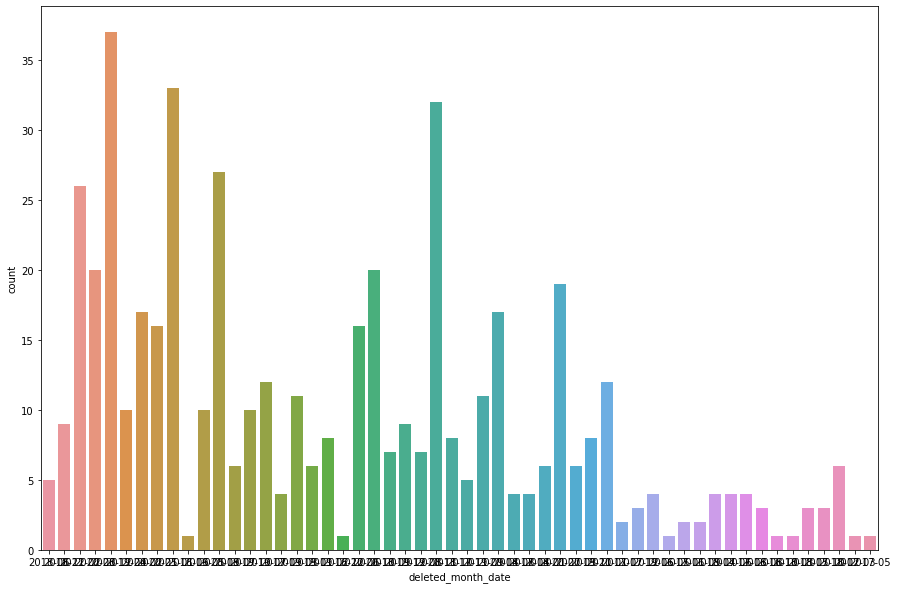

In [59]:
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(x='deleted_month_date', data=df)